# My First Notebook Project - Unsupervised Learning Trading Strategy

## Install all packages using pip3 and import into the program.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500["Symbol"] = sp500["Symbol"].str.replace(".","-")

SymbolsList = sp500["Symbol"].unique().tolist()

end_date = "2023-09-27"


startdate = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = SymbolsList, start = startdate, end = end_date)

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['SOLV', 'VLTO', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [3]:
print(df)
df  = df.stack()
print(df)
df.columns = df.columns.str.lower()
print(df)


Price        Adj Close                                                 \
Ticker               A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2015-09-29   31.483553  37.361618   24.684566   36.334904         NaN   
2015-09-30   32.034111  37.027863   24.965233   37.449932         NaN   
2015-10-01   31.483553  37.380699   24.802263   37.945507         NaN   
2015-10-02   32.351353  36.837151   24.983334   38.420425         NaN   
2015-10-05   32.976566  38.324745   25.073872   39.012360         NaN   
...                ...        ...         ...         ...         ...   
2023-09-20  111.872437  13.060000  175.035751  149.254456  138.009995   
2023-09-21  109.146988  13.060000  173.479797  149.079544  132.750000   
2023-09-22  110.818077  12.900000  174.337555  148.409119  132.199997   
2023-09-25  111.345245  12.910000  175.624222  150.264954  134.139999   
2023-09-26  110.141678  12.700000  171.514893  149.

## Calculate features and technical indicators for each stock.

Price               adj close       close        high         low        open  \
Date       Ticker                                                               
2015-09-29 A        31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684566   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478699   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.54769

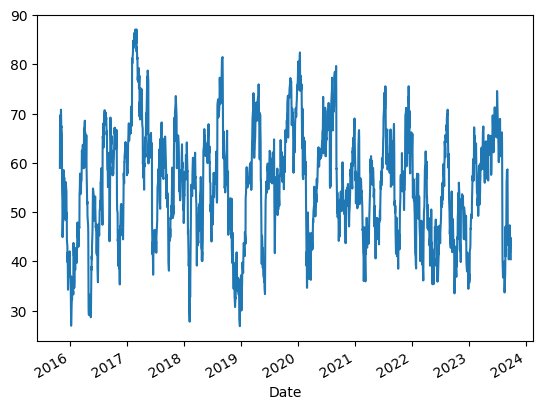

In [4]:
df["garman_klass_vol"] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2) - 1)*((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))


df.xs('AAPL',level=1)['rsi'].plot()

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_upp'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'], low = stock_data['low'],close = stock_data['close'], length = 14)
    # return the standardized atr
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)



def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


print(df)


## Aggregate to a monthly level and filter the top 150 most liquid stocks for each month

In [40]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

last_cols

data = pd.concat([df.unstack('Ticker')['dollar_volume'].resample('M').mean().stack('Ticker').to_frame('dollar_volume'),
                df.unstack()[last_cols].resample('M').last().stack('Ticker')],axis=1).dropna()

data

dollar_volume   adj close       atr    bb_low    bb_mid  \
Date       Ticker                                                            
2015-11-30 A          135.992834   39.023193 -1.033887  3.545992  3.618440   
           AAL        287.915801   39.429932  0.190822  3.672028  3.749832   
           AAPL      4029.441996   26.890554 -0.967900  3.282983  3.326297   
           ABBV       337.563925   40.393532 -0.526809  3.726695  3.774943   
           ABT        211.659055   38.293575 -1.064842  3.656055  3.677909   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983158   78.671936 -1.028320  4.374104  4.419394   
           ABNB      1633.500725  132.279999 -1.006939  4.857047  4.940924   
           CEG        196.971016  108.026917 -0.436215  4.653660  4.693834   
           GEHC       212.275852   66.130219 -0.893478  4.155436  4.212972   
           KVUE       670.804304   20.006193 -0.899746  3.014275  3.089221   

                     bb_upp  garman_klass_vol      macd        rsi  
Date       Ticker                                                   
2015-11-30 A       3.690888         -0.001992  0.567158  73.421420  
           AAL     3.827635         -0.000966 -0.418772  40.718961  
           AAPL    3.369611         -0.003209 -0.142790  55.537296  
           ABBV    3.823191         -0.059549  0.145677  49.376871  
           ABT     3.699763         -0.011216  0.335558  56.962601  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.464683         -0.000020 -1.534536  33.116217  
           ABNB    5.024801          0.000213 -0.037854  44.494127  
           CEG     4.734007          0.000171  0.366876  55.245482  
           GEHC    4.270508          0.000185 -1.116463  40.922338  
           KVUE    3.164168         -0.000159 -1.435621  35.706310  

[46692 rows x 9 columns]

In [41]:
data['dollar_volume']  = (data.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_volume_rank'] = data.groupby('Date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume','dollar_volume_rank'], axis=1)

data

adj close       atr    bb_low    bb_mid    bb_upp  \
Date       Ticker                                                       
2016-10-31 AAL      39.134327  0.402199  3.604673  3.655493  3.706314   
           AAPL     26.248028 -1.038688  3.295542  3.324423  3.353305   
           ABBV     40.245121 -0.893132  3.753446  3.807610  3.861774   
           ABT      34.293461 -1.035224  3.554632  3.605106  3.655580   
           ACN     103.569633 -0.996806  4.637342  4.648980  4.660617   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783058 -0.196381  3.988367  4.005838  4.023309   
           XOM     114.292961  0.601335  4.695106  4.735205  4.775304   
           MRNA     98.120003 -0.529511  4.582514  4.685332  4.788149   
           UBER     44.270000 -0.746098  3.806654  3.862227  3.917801   
           ABNB    132.279999 -1.006939  4.857047  4.940924  5.024801   

                   garman_klass_vol      macd        rsi  
Date       Ticker                                         
2016-10-31 AAL            -0.000176  1.131596  62.203556  
           AAPL           -0.002384 -0.195978  49.891086  
           ABBV           -0.046691 -0.760594  27.477625  
           ABT            -0.007492 -0.650888  38.008819  
           ACN            -0.004643 -0.135456  53.823679  
...                             ...       ...        ...  
2023-09-30 WMT            -0.000011  0.399458  54.722523  
           XOM             0.000026  1.400623  59.440186  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

In [42]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr    bb_low    bb_mid    bb_upp  \
Date       Ticker                                                       
2017-10-31 AAL      45.534168  1.011062  3.849110  3.921750  3.994389   
           AAPL     39.767761 -0.906642  3.596049  3.642922  3.689796   
           ABBV     67.491150  0.375557  4.196702  4.243063  4.289423   
           ABT      48.493378 -1.040044  3.892568  3.916137  3.939707   
           ACN     129.399689 -0.986514  4.802675  4.842354  4.882034   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783058 -0.196381  3.988367  4.005838  4.023309   
           XOM     114.292961  0.601335  4.695106  4.735205  4.775304   
           MRNA     98.120003 -0.529511  4.582514  4.685332  4.788149   
           UBER     44.270000 -0.746098  3.806654  3.862227  3.917801   
           ABNB    132.279999 -1.006939  4.857047  4.940924  5.024801   

                   garman_klass_vol      macd        rsi  return_1m  \
Date       Ticker                                                     
2017-10-31 AAL            -0.000363 -0.018697  41.051783  -0.014108   
           AAPL           -0.000998 -0.039276  69.196611   0.096808   
           ABBV           -0.034008  0.473815  55.247891   0.022728   
           ABT            -0.005190  0.276133  53.844940   0.021275   
           ACN            -0.003925  0.352342  69.365220   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT            -0.000011  0.399458  54.722523  -0.000676   
           XOM             0.000026  1.400623  59.440186   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10346 rows x 14 columns]

## Downloading more data

In [52]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'Date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056889
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10346 rows x 6 columns]

In [62]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056889
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10317 rows x 6 columns]

In [67]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165644  0.267344  0.310367  0.106902
           WFC     1.121746  0.300523  2.061531 -0.439488 -1.517556
           WMT     0.700557 -0.315599 -0.413434 -0.142907  0.508473
           XOM     0.983510 -1.093758  1.756776 -0.640866 -0.368454

[10317 rows x 5 columns]

In [77]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

#data = data.join(betas.groupby('Ticker').shift())

#data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

#data = data.drop('adj close', axis=1)

#data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10135 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10135 non-null  float64
 1   bb_low            10135 non-null  float64
 2   bb_mid            10135 non-null  float64
 3   bb_upp            10135 non-null  float64
 4   garman_klass_vol  10135 non-null  float64
 5   macd              10135 non-null  float64
 6   rsi               10135 non-null  float64
 7   return_1m         10135 non-null  float64
 8   return_2m         10135 non-null  float64
 9   return_3m         10135 non-null  float64
 10  return_6m         10135 non-null  float64
 11  return_9m         10135 non-null  float64
 12  return_12m        10135 non-null  float64
 13  Mkt-RF            10135 non-null  float64
 14  SMB               10135 non-null  float64
 15  HML       